# An introduction to the Well Logs package

`PetroFlow` is a package, designed to conveniently process well logs data. It is based on a very simple and natural approach:
* Split an input dataset into batches to process them independently
* Describe a workflow as a sequence of actions (e.g., load data — preprocess data — train a model)
* Run the workflow for the whole dataset a number of times

In this notebook you will learn:
* How to start using `PetroFlow`
* How to apply actions to a batch
* How different actions transform a batch and its components

## Contents
* [Creating a dataset](#Creating-a-dataset)
* [Generating batches](#Generating-batches)
* [Applying actions](#Applying-actions)
* [Actions in PetroFlow](#Actions-in-PetroFlow)
    * [drop_nans](#drop_nans)
    * [random_crop](#random_crop)
    * [crop](#crop)
    * [aggregate](#aggregate)
* [Summary](#Summary)

## Creating a dataset

`PetroFlow` contains two main classes: `WellLogsBatch`, that stores log data and contains various processing methods, and `WellLogsDataset`, a subclass of a `batchflow.Dataset`, that simply generates batches of a class `WellLogsBatch`.

In [1]:
import sys
sys.path.insert(0, "..")

import numpy as np

from petroflow import WellLogsDataset

To start working with the package, we first need to create a dataset by passing a path to a directory with logs:

In [2]:
DATA_PATH = "/path/to/data/*.npz"
ds = WellLogsDataset(path=DATA_PATH, no_ext=True, sort=True)

Now each well is indexed with its filename without extension, as it is defined by `no_ext` argument. Indices are stored in `ds.indices` attribute in a sorted order:

In [3]:
ds.indices

array(['1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype='<U67')

## Generating batches

Now we can generate a batch of logs of some size, say 3, by calling `next_batch` method:

In [4]:
batch = ds.next_batch(batch_size=3)

The resulting object has three attributes, that are called `components`:
* `dept` — contains information about depth for each sample
* `logs` — stores logs themselves in a channels first format
* `meta` — stores additional metadata about logs, such as mnemonics for each channel

However, the `batch` does not yet contain any data, now it stores only indices and paths to the logs. To fill it with data we need to apply `load` action, which will be described in the next section.

## Applying actions

Working with batches typically starts with the loading of data, which can be performed with the help of `load` method:

In [5]:
batch = batch.load(fmt="npz", components=["dept", "logs"])

In [6]:
batch.indices

array(['1', '2', '3'], dtype='<U67')

Note that paths to logs are already stored in the index of the batch, so we only need to specify data format and components we want to load. In the case of `npz` format, arrays, that are not listed in the `components` argument, are stored in `meta` component under the same keys.

Now `batch_with_data` contains loaded logs for each well in the batch. Data for each particular well can be accessed by its index:

In [7]:
item = batch["1"]

Data in the `dept`, `logs` and `meta` components can be obtained by the regular attribute syntax:

In [8]:
item.dept

array([  20. ,   20.1,   20.2, ..., 2839.7, 2839.8, 2839.9])

In [9]:
item.logs

array([[   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ..., 65.446, 63.535, 62.261],
       [ 1.777,  1.777,  1.739, ...,    nan,    nan,    nan],
       ...,
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]])

In [10]:
item.meta

{'mnemonics': array(['CFTC', 'CILD', 'GR', 'GZ1', 'GZ2', 'GZ3', 'GZ4', 'GZ7', 'LLD',
        'NKTD', 'PROX', 'SP'], dtype='<U4'),
 'mask': array([0., 0., 0., ..., 0., 0., 0.])}

Also we can get access to these components for the whole batch:

In [11]:
batch.dept

array([array([  20. ,   20.1,   20.2, ..., 2839.7, 2839.8, 2839.9]),
       array([  26.4,   26.5,   26.6, ..., 2739.3, 2739.4, 2739.5]),
       array([  20. ,   20.1,   20.2, ..., 2845.1, 2845.2, 2845.3])],
      dtype=object)

Now let's plot the loaded logs for the first well:

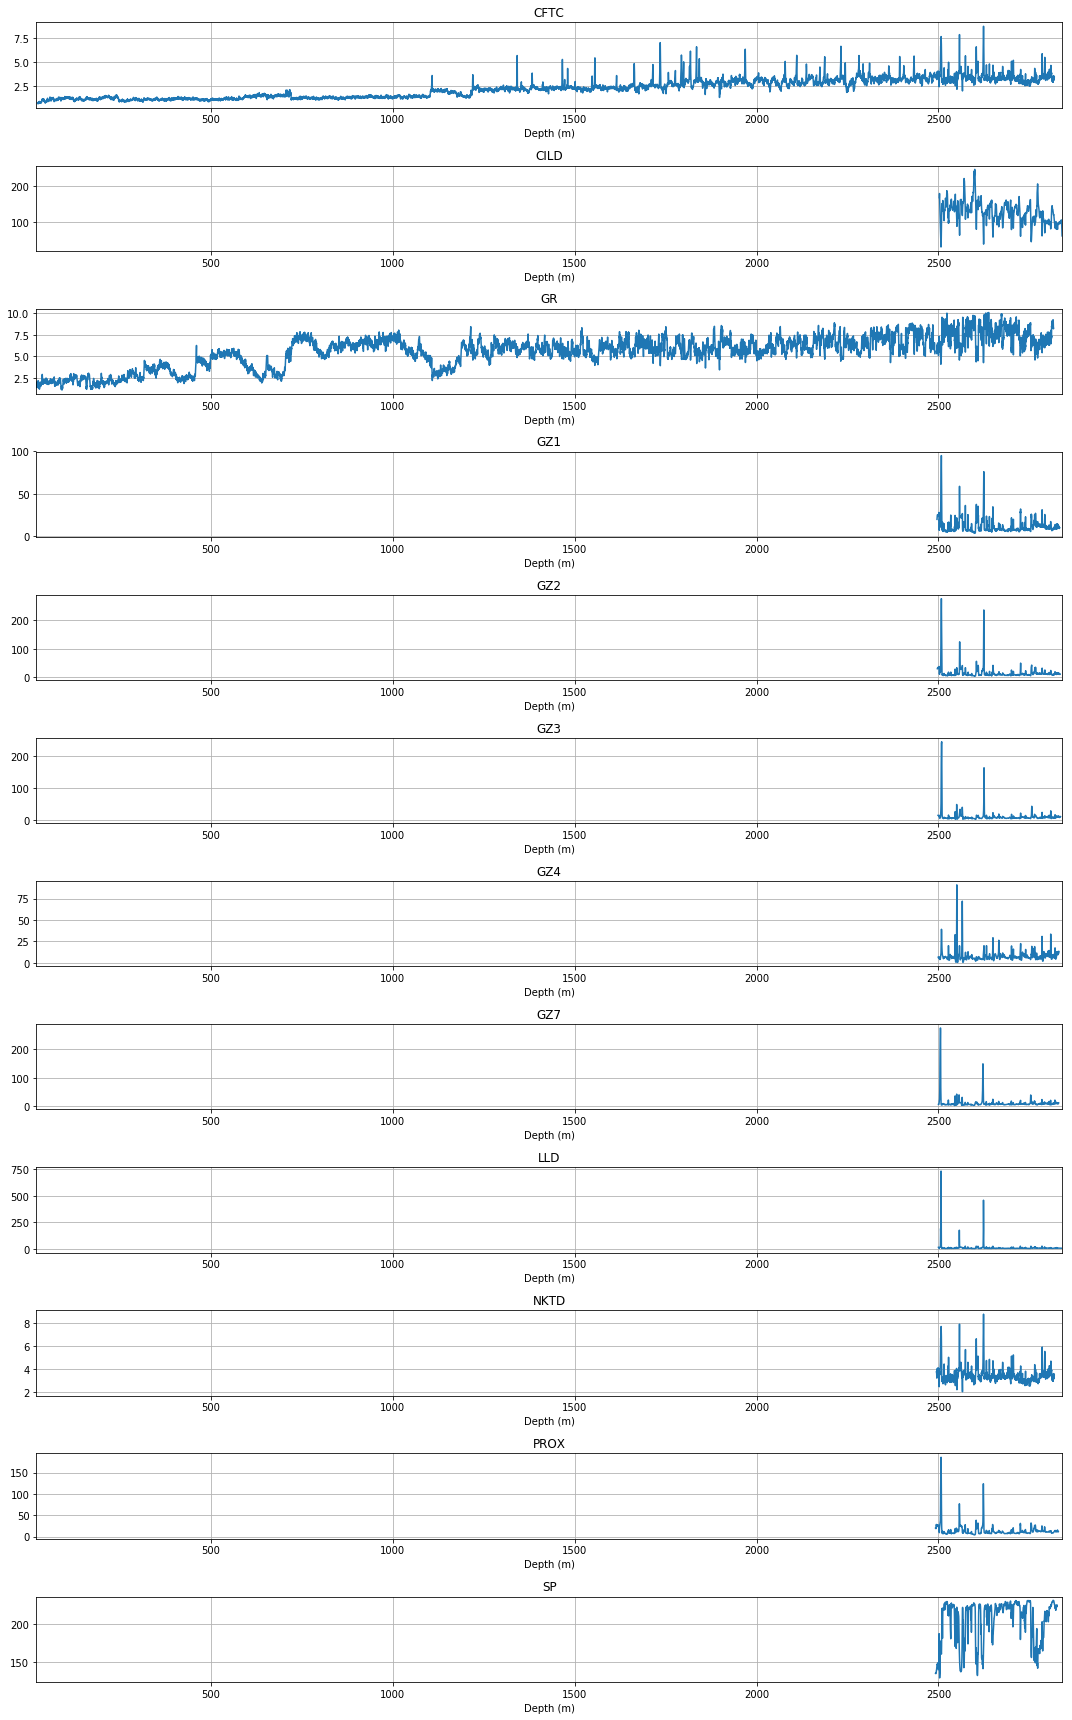

In [12]:
batch._show_logs()

## Actions in PetroFlow

`PetroFlow` contains various actions for well logs processing. Here are some of them:
* drop_nans
* random_crop
* crop
* aggregate

In the following sections we will show how to use them and how these actions affect a batch and its components.

### drop_nans

As we can see on the plot above, usually logs are taken only for a small part of a wellbore. The easiest way to train classical neural network architectures on such data is to select only those part of logs, where all of them have not-nan values simultaneously. This is exactly what `drop_nans` action does:

In [13]:
batch = batch.drop_nans()

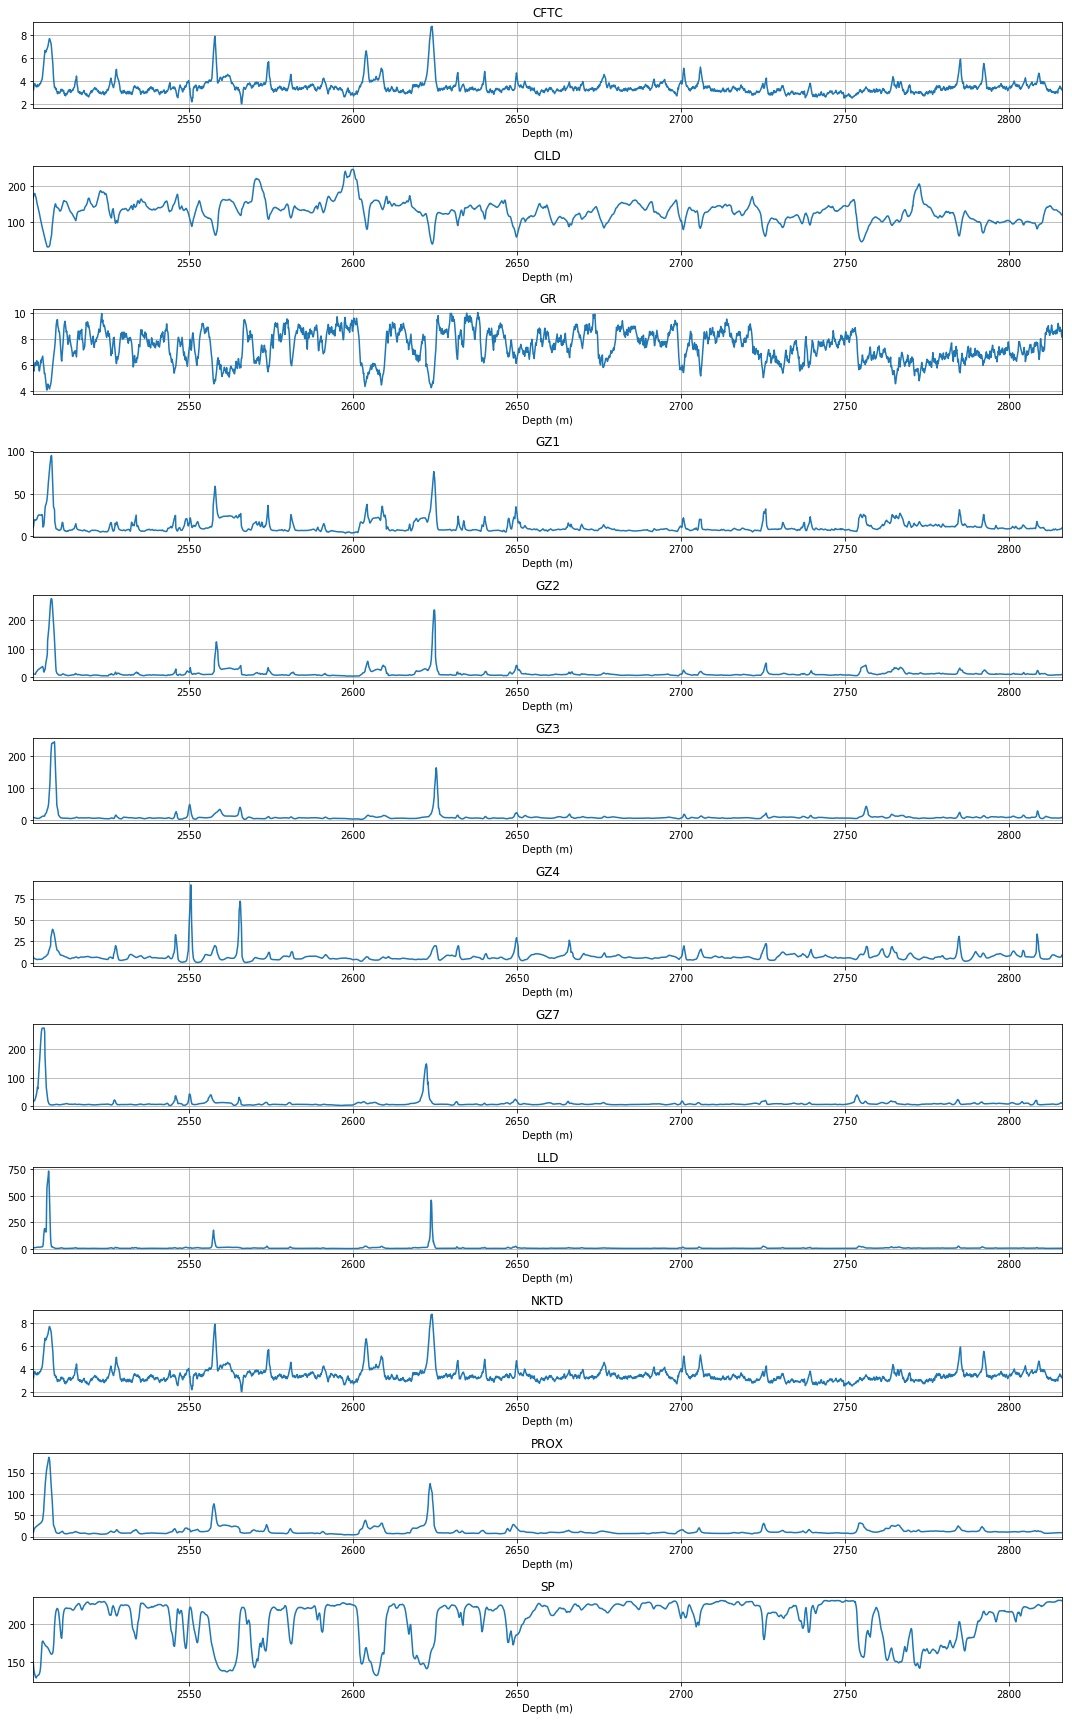

In [14]:
batch._show_logs()

As a result, data form approximately 2500 to 2800 meters was kept where all logs were recorded.

### random_crop

Well logs, measured in different wells, have different lengths, while many neural network architectures require their input to be fixed-sized. One way to accomplish this would be to call ``random_crop`` method, which picks ``n_crops`` segments from given ``components`` along the last axis with random start positions and given ``length``:

In [15]:
split_batch = batch.deepcopy()
split_batch = split_batch.random_crop(length=256, n_crops=4, components="logs")

Notice, that each element of the resulting components will have an additional axis with index 0, along which cropped segments were stacked:

In [16]:
print("Original logs shape: ", batch.logs[0].shape)
print("Shape of the logs after random cropping: ", split_batch.logs[0].shape)

Original logs shape:  (12, 3139)
Shape of the logs after random cropping:  (4, 12, 256)


### crop

``crop`` method is similar to ``random_crop``, but instead of random selection of segments, it crops them deterministically by shifting the next segment relative to the previous one by ``step`` positions:

In [17]:
split_batch = batch.deepcopy()
split_batch = split_batch.crop(length=256, step=128, components="logs")

In [18]:
print("Original logs shape: ", batch.logs[0].shape)
print("Shape of the logs after cropping: ", split_batch.logs[0].shape)

Original logs shape:  (12, 3139)
Shape of the logs after cropping:  (24, 12, 256)


This action can be useful for making inference on inputs of varying length in such tasks as semantic segmentation.

### aggregate

This action undoes the application of ``crop`` method by iteratively aggregating the resulting crops using ``agg_fn`` at all depths along the wellbore. Also, in the case of semantic segmentation, it can be used to merge model predictions for different crops into a mask for the entire well log.

Let's try to use ``aggregate`` to reconstruct ``logs`` component after performing ``crop`` action and check if the reconstruction matches the original logs:

In [19]:
split_batch = batch.deepcopy()
split_batch = split_batch.crop(length=256, step=128, components="logs")
restored_batch = split_batch.aggregate(agg_fn="mean", components="logs")

In [20]:
all(np.allclose(l1, l2) for l1, l2 in zip(batch.logs, restored_batch.logs))

True

## Summary

Summarizing, in this tutorial we've learned:
* How to create datasets
* How to apply actions
* How actions change a batch and its components